# Conllu Data Filtering
purpose of this notebook is to evaluate the quality of raw recipes.
Quality is measured by the following criterias:

* Length of the recipe (shorter recipes without unnecessary information are better)
    * (maybe also length of single sentences)
* Ratio of cooking keywords vs other words
* **TODO**: more to come…

In [1]:
from conllu_batch_generator import ConlluReader
import numpy as np
from crf_data_generator import *

In [2]:
import plotly
plotly.__version__

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import sys
sys.path.insert(0, '..')  # noqa
import settings  # noqa

In [3]:
from IPython.display import Markdown

In [4]:
#cr  = ConlluReader("../" + settings.gzipped_conllu_data_root + "recipes0.conllu.gz", iter_documents=True)
cr  = ConlluReader("recipes3.conllu", iter_documents=True, return_recipe_ids=True)

In [5]:
import pycrfsuite

tagger = pycrfsuite.Tagger()
tagger.open('test.crfsuite')

class recipe(object):
    def __init__(self, sentences_list: list, recipe_id = None):
        """
        @param sentences_list: list of token_lists
        """
        self._sentences = []
        self._recipe_id = recipe_id
        for sent in sentences_list:
            if len(sent) > 0:
                self._sentences.append(sent)
    
    def avg_sentence_length(self):
        return sum([len(s) for s in self._sentences])/len(self._sentences)
    
    def n_instructions(self):
        return len(self._sentences)
    
    def max_sentence_length(self):
        return max([len(s) for s in self._sentences])
    
    def keyword_ratio(self):
        sentence_ratios = []
        for sent in self._sentences:
            # FIXME: only works if there are no other misc annotations!
            sentence_ratios.append(sum([token['misc'] is not None for token in sent]))
        return sum(sentence_ratios) / len(sentence_ratios)
    
    def predict_labels(self):
        features = [sent2features(sent) for sent in self._sentences]
        labels = [tagger.tag(feat) for feat in features]
        return labels
    
    def recipe_id(self):
        return self._recipe_id
    
    def serialize(self):
        result = "# newdoc\n"
        if self._recipe_id is not None:
            result += f"# id: {self._recipe_id}\n"
        
        for sent in self._sentences:
            result += f"{sent.serialize()}"
        return result + "\n"
    
    def __repr__(self):
        s = "recipe: " + (self._recipe_id if self._recipe_id else "") + "\n"
        s += "instructions: \n"
        for sent in self._sentences:
            s += " ".join([token['form'] for token in sent]) + "\n"
        
        s += "\nscores:\n"
        s += f"avg_sent_length: {self.avg_sentence_length()}\n"
        s += f"n_instructions: {self.n_instructions()}\n"
        s += f"keyword_ratio: {self.keyword_ratio()}\n\n\n"
        
        return s

In [6]:

#for i, r in enumerate(cr):
#    display(recipe(r))
#    if i > 20:
#        break

In [7]:
n_instructions_counter = []
avg_sent_counter = []
keyword_ratio_counter = []
max_sent_counter = []

for r, recipe_id in cr:
    rec = recipe(r, recipe_id)
    n_instructions_counter.append(rec.n_instructions())
    avg_sent_counter.append(rec.avg_sentence_length())
    keyword_ratio_counter.append(rec.keyword_ratio())
    max_sent_counter.append(rec.max_sentence_length())

In [8]:
len(n_instructions_counter)

5000

## Recipe Analysis

### number of instruction's distribution

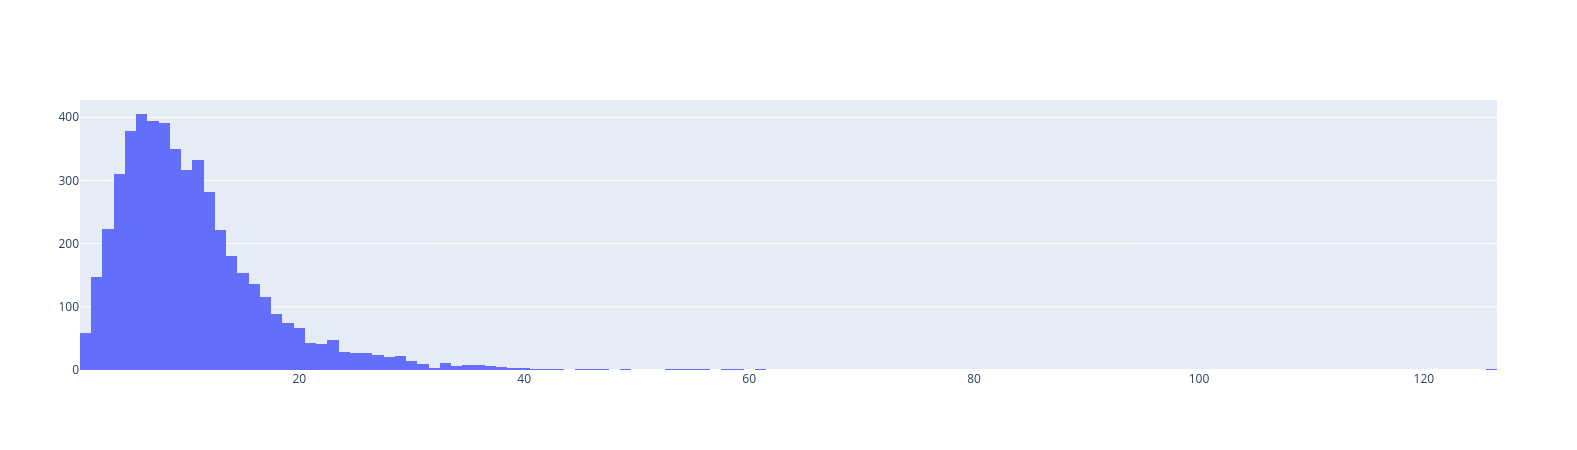

### distribution of avergage sentence length

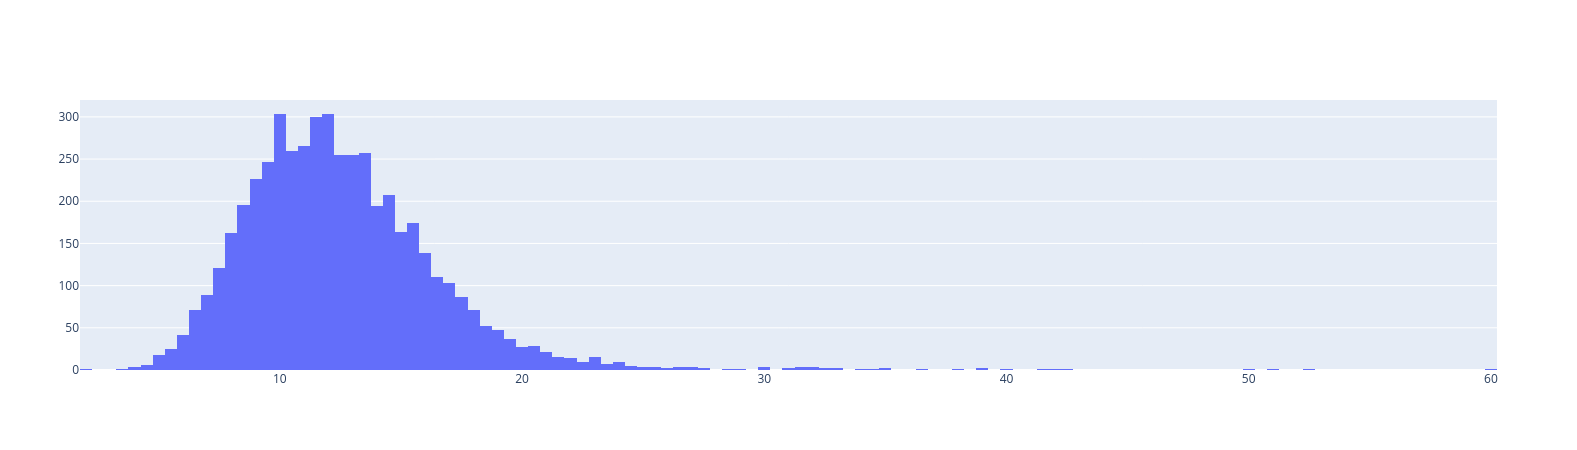

### distribution of keyword ratio

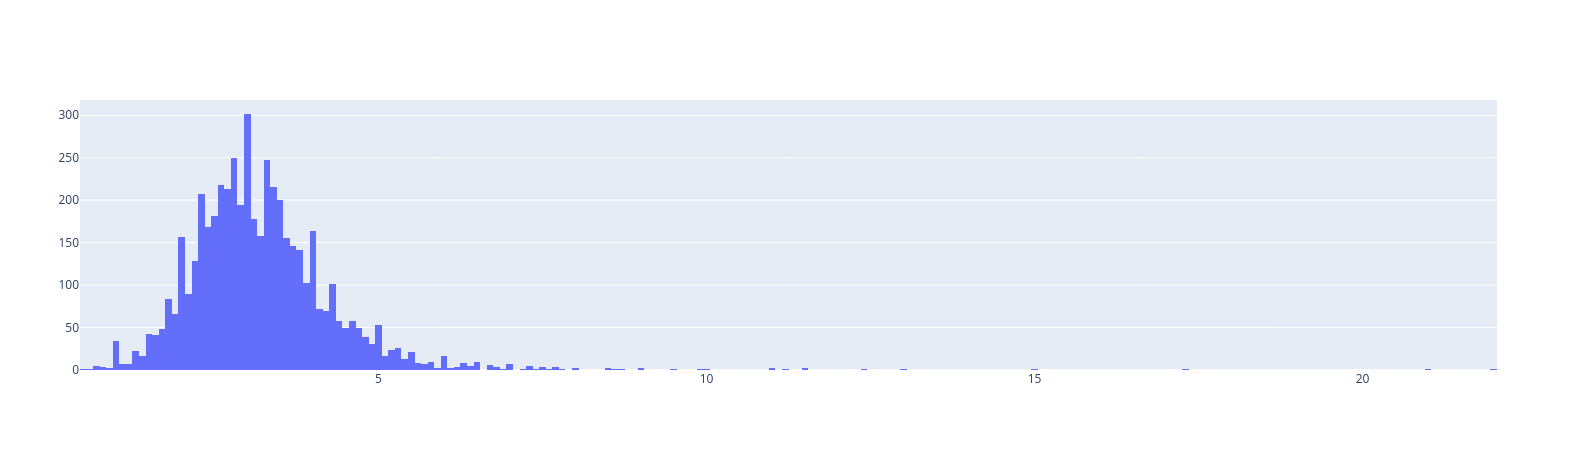

### distribution of max sentence length

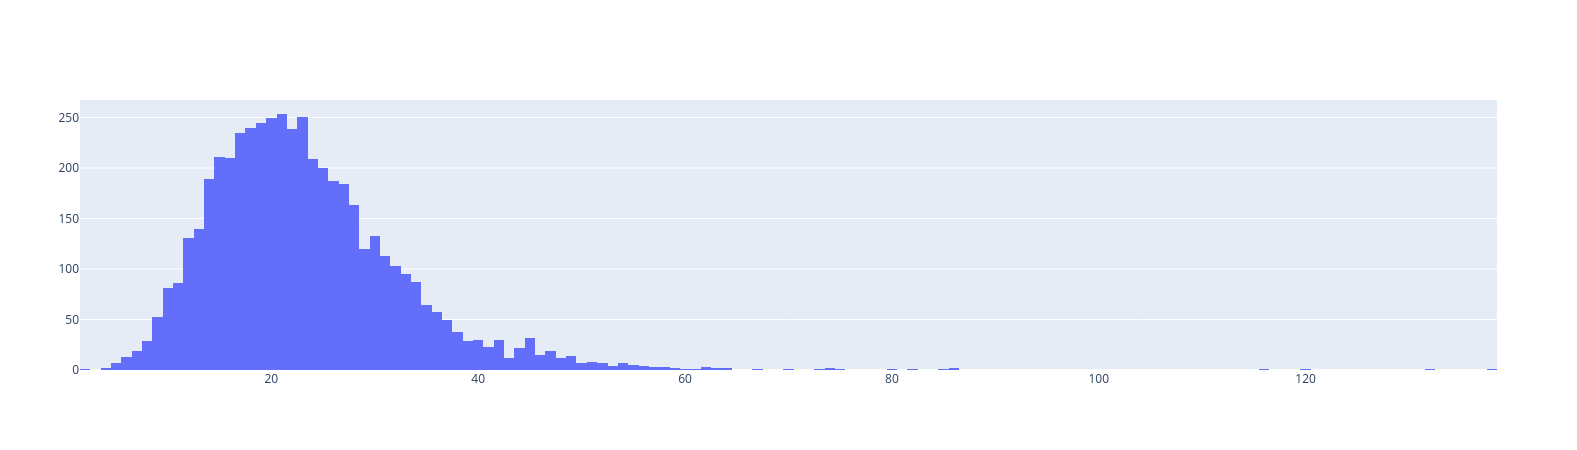

In [9]:
display(Markdown("## Recipe Analysis"))

data = go.Histogram(x=np.sort(n_instructions_counter))
display(Markdown("### number of instruction's distribution"))
iplot([data])

data = go.Histogram(x=np.sort(avg_sent_counter))
display(Markdown("### distribution of avergage sentence length"))
iplot([data])

data = go.Histogram(x=np.sort(keyword_ratio_counter))
display(Markdown("### distribution of keyword ratio"))
iplot([data])

data = go.Histogram(x=np.sort(max_sent_counter))
display(Markdown("### distribution of max sentence length"))
iplot([data])

cumulative plots

### number of instruction's distribution

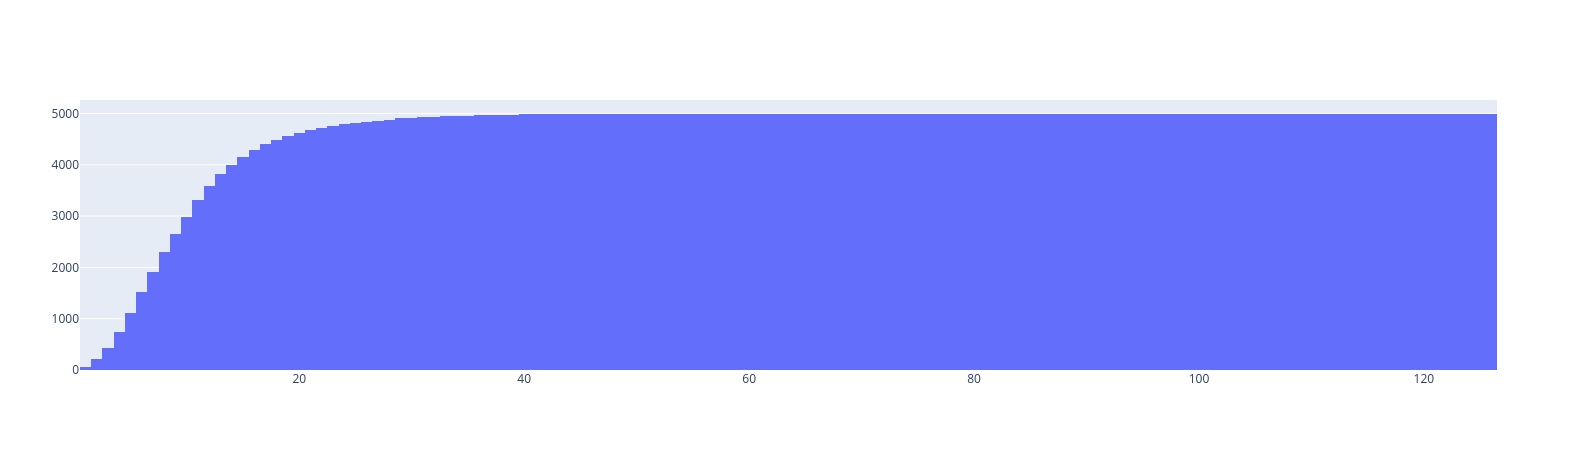

### distribution of avergage sentence length

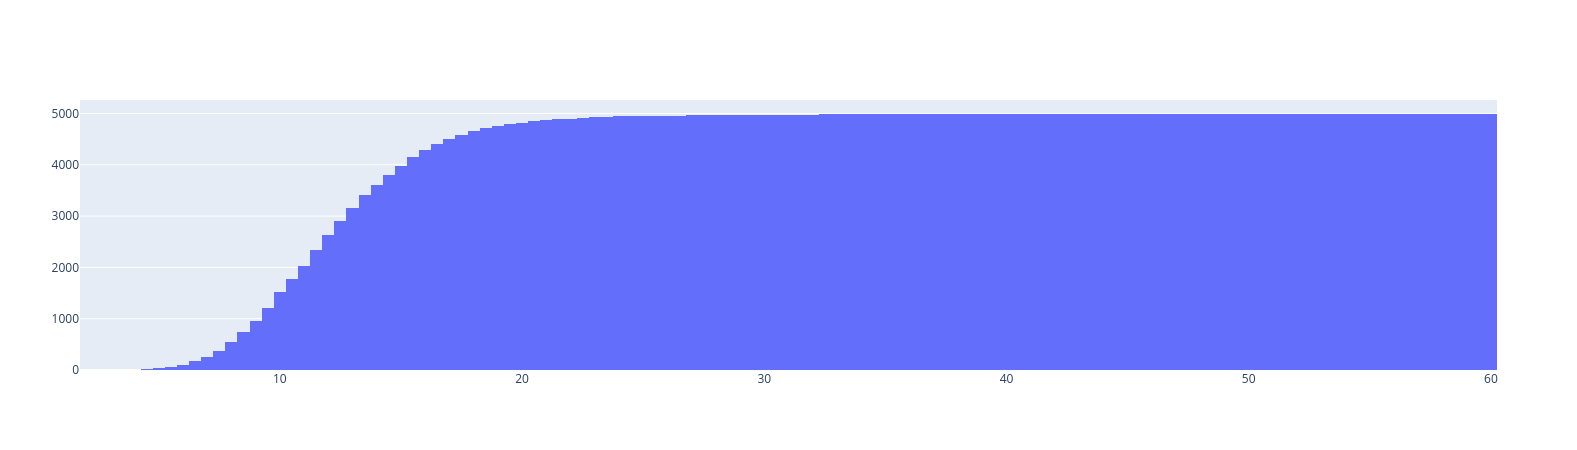

### distribution of keyword ratio

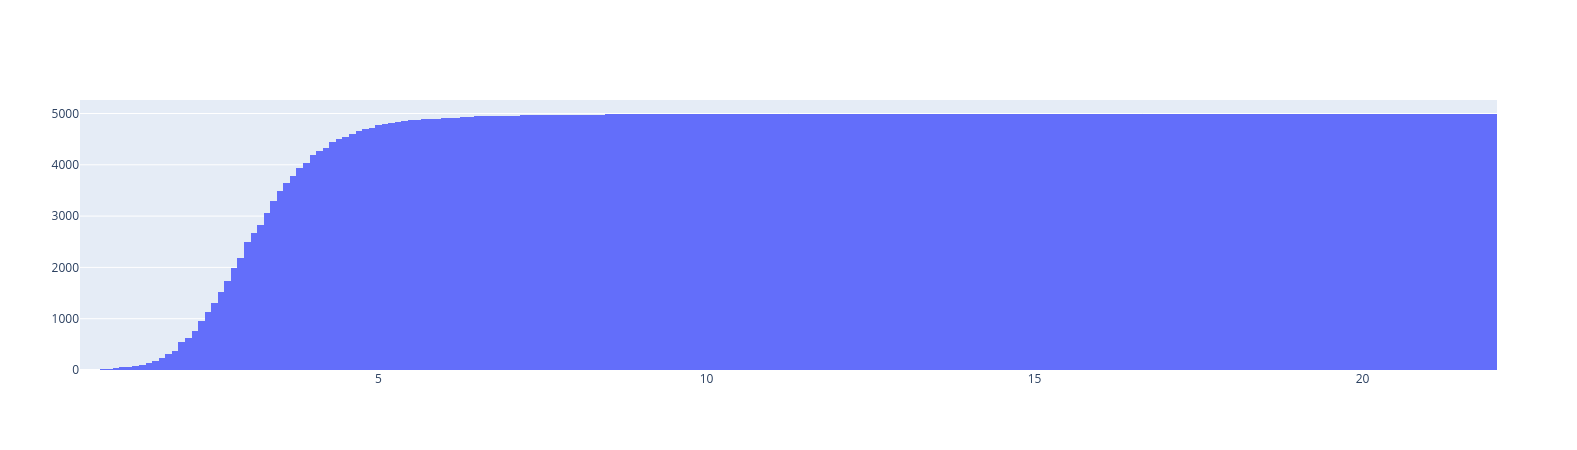

In [10]:
display(Markdown("cumulative plots"))

data = go.Histogram(x=np.sort(n_instructions_counter), cumulative=dict(enabled=True))
display(Markdown("### number of instruction's distribution"))
iplot([data])

data = go.Histogram(x=np.sort(avg_sent_counter), cumulative=dict(enabled=True))
display(Markdown("### distribution of avergage sentence length"))
iplot([data])

data = go.Histogram(x=np.sort(keyword_ratio_counter), cumulative=dict(enabled=True))
display(Markdown("### distribution of keyword ratio"))
iplot([data])

## filter recipes by these parameters:

In [13]:
cr  = ConlluReader("all_recipes.conllu.gz", iter_documents=True, return_recipe_ids=True)

In [14]:
filtered_file = open("filtered_recipes.conllu", "w")

recipes = []

threshold_n_instructions = 10
threshold_avg_sentence_length = 10
threshold_keyword_ratio = 3
threshold_max_sent_length = 15

In [15]:


for r, i in cr:
    rec = recipe(r, i)
    
    if rec.n_instructions() < threshold_n_instructions:
        if rec.avg_sentence_length() < threshold_avg_sentence_length:
            if rec.keyword_ratio() < threshold_keyword_ratio:
                if rec.max_sentence_length() < threshold_max_sent_length:
                    recipes.append(rec)
                    filtered_file.write(rec.serialize())
    '''
    if rec.keyword_ratio() < threshold_keyword_ratio:
        recipes.append(rec)
    '''
filtered_file.close()

In [17]:
len(recipes)

9560

In [18]:
from IPython.core.display import Markdown, HTML, display

#tagger = pycrfsuite.Tagger()
#tagger.open('test.crfsuite')

In [19]:
def sentence_as_markdown_table( tokens, labels = None, predictions = None):
    n = len(tokens)
    s = "<table>\n<tr>\n<th>Sentence:</th>\n"
    for t in tokens:
        s += f"<th>{t}</th>"
    
    s += "<tr>\n"
    
    if labels is not None:
        s += "<th>labels:</th>" + "".join([f"<th>{l}</th>" for l in labels])
        s += "</tr>\n"
    
    if predictions is not None:
        s+= "<th>Predicitions:</th>" + "".join([f"<th>{p}</th>" for p in predictions])
    
    display(HTML(s + "</tr>\n</table>\n"))

## display example recipes

In [20]:
j = 0

n = 200

cr =  ConlluReader("filtered_recipes.conllu", iter_documents=True, return_recipe_ids=True)

for raw_r, id_r in cr:
    if j > n:
        break
    j += 1
    rec = recipe(raw_r, id_r)
    print("recipe: " + str(rec._recipe_id))
    predictions = rec.predict_labels()
    for i, sent in enumerate(rec._sentences):
        tokens = [token['form'] for token in sent]
        labels = []
        for token in sent:
            if token['misc'] is None or 'food_type' not in token['misc']:
                labels.append("0")
            else:
                labels.append(token['misc']['food_type'])
        
        sentence_as_markdown_table(tokens, labels, predictions[i])
        
    print("\n\n")
    

recipe: 00004320bb





recipe: 000095fc1d





recipe: 0001d81db6





recipe: 0002a82634





recipe: 0004c0a2a8





recipe: 0004c7c040





recipe: 0004d8bd26





recipe: 0004fcb850





recipe: 00052b48d3





recipe: 000535f6ea





recipe: 00058111f2





recipe: 0006c5e4eb





recipe: 0007013e7e





recipe: 0007cacb2d





recipe: 0007fc5d26





recipe: 000875a149





recipe: 000aaf960b





recipe: 000b0b5d50





recipe: 000b5bbd1d





recipe: 000bcc1e31





recipe: 000d5e4996





recipe: 000eb2a4d9





recipe: 000ee3c428





recipe: 001038045f





recipe: 001160531e





recipe: 00127b57b1





recipe: 00129c6253





recipe: 0013797989





recipe: 0015a0ed8e





recipe: 0016145ed6





recipe: 00168e345c





recipe: 0016f38e7e





recipe: 00185a60a8





recipe: 001a6c3324





recipe: 001b2ddde5





recipe: 001b4d55a6





recipe: 001cc0fe60





recipe: 001d75f126





recipe: 001da6fa18





recipe: 001e8fc9d8





recipe: 001f8b08ac





recipe: 001f938961





recipe: 001fcb23b8





recipe: 002079d702





recipe: 0020d1020c





recipe: 002185f971





recipe: 00236b03c6





recipe: 00237cfc61





recipe: 0023947e8a





recipe: 0023a9cd31





recipe: 0023ef9356





recipe: 0024edc2df





recipe: 0025335b26





recipe: 002674872e





recipe: 0027203dbe





recipe: 0027959b09





recipe: 0028515796





recipe: 002853e034





recipe: 0028c4f877





recipe: 00293e8e4d





recipe: 0029d8d420





recipe: 002acfb500





recipe: 002b2bd66a





recipe: 002b9cecad





recipe: 002c6dc181





recipe: 002cb4f282





recipe: 002cc78992





recipe: 002cc9ec2c





recipe: 002d9b8fee





recipe: 002dd801a4





recipe: 002e719123





recipe: 002e896c26





recipe: 002f3954a0





recipe: 0031110b9a





recipe: 0031197ac6





recipe: 003144adb6





recipe: 0032122327





recipe: 003438622f





recipe: 00348377bf





recipe: 0034f1549f





recipe: 00360bbfca





recipe: 0037245cf3





recipe: 0037897776





recipe: 003ac076a2





recipe: 003ac7d3db





recipe: 003c17c817





recipe: 003c28e9ed





recipe: 003c54f90b





recipe: 003c9f5fbb





recipe: 003ca0c942





recipe: 003d041add





recipe: 003e039a5d





recipe: 003e94bef3





recipe: 003f5e4132





recipe: 003f786b7c





recipe: 0041022e38





recipe: 00419f62be





recipe: 0041e52c09





recipe: 0041f3b796





recipe: 0042ff4b6f





recipe: 0043fc4435





recipe: 00443b51d0





recipe: 0045561971





recipe: 0046f4c349





recipe: 00481a8aaa





recipe: 0048cf71ad





recipe: 004979f520





recipe: 004a0770d9





recipe: 004a8b14d5





recipe: 004c4da6a7





recipe: 004d949471





recipe: 004d9712b6





recipe: 004dde4b1d





recipe: 004f24636f





recipe: 00505f2205





recipe: 0050b41138





recipe: 0050eb2f27





recipe: 0051a26cb4





recipe: 0051c61360





recipe: 00520568dd





recipe: 0052902813





recipe: 005503aa9e





recipe: 0057b2b137





recipe: 00597321e1





recipe: 0059ef1ab4





recipe: 005af4565f





recipe: 005c8e4379





recipe: 005cdbc0ca





recipe: 005d002123





recipe: 005ec98a52





recipe: 005f01f360





recipe: 005f1948be





recipe: 005f456515





recipe: 005fc92999





recipe: 00602c3d13





recipe: 0060734282





recipe: 0061b1a2c4





recipe: 00647fdde2





recipe: 0065a67785





recipe: 006602ed69





recipe: 0067397bcf





recipe: 00675f64c3





recipe: 0067a39001





recipe: 0069526e47





recipe: 006966fdfc





recipe: 00697220f3





recipe: 006a615f7c





recipe: 006a73219e





recipe: 006c04c8ca





recipe: 006c622cbc





recipe: 006cacf69a





recipe: 006ceb7fe2





recipe: 006dbad7d9





recipe: 006ff88be1





recipe: 0070cfd592





recipe: 00717dfb96





recipe: 0071ac848a





recipe: 0071d5d4a2





recipe: 0073191039





recipe: 007405f60d





recipe: 00748db16c





recipe: 00749f46c0





recipe: 0074aa2480





recipe: 0074fb7d59





recipe: 0075c6e4b9





recipe: 0077151f0d





recipe: 00779bc1f2





recipe: 0077df06da





recipe: 00781763ec





recipe: 00783fad09





recipe: 007891436c





recipe: 00795b404b





recipe: 0079d6f89e





recipe: 007a80623a





recipe: 007b7d82d5





recipe: 007cb091c8





recipe: 007d6ab439





recipe: 007db2771c





recipe: 007e8596c9





recipe: 007ef0f9a3





recipe: 007fd3cd60





recipe: 0081bb07c7





recipe: 0081bb2b38





recipe: 0083031ddf





recipe: 008357d71a





recipe: 008390c493





recipe: 0083a374f4





recipe: 008561f7b3





recipe: 00859a572d





recipe: 0085fdf3c1





recipe: 00866c1558





recipe: 0087555f83





recipe: 008aaff439





recipe: 008b141537





recipe: 008bf2a6e5





recipe: 008c4c00bd





recipe: 008c50aa78





recipe: 008c554535





recipe: 008c8cd872





recipe: 008cc20257





recipe: 008cf969a9
